Let's build a transformer for the **question answering** task. The transformer will work on the principle of a chatbot: accept a question as input and generate an answer to this question. As a dataset we will use Russian-language dialog from [Denchik with HuggingFace](https://huggingface.co/datasets/Den4ikAI/russian_dialogues).

Dataset of Russian dialogs collected from Telegram chats. Dialogs have relevance markup. Negative examples were also generated by mixing similar answers.

Number of dialogs - 2 million.

## Install and import necessary libraries

In [ ]:
# Let's install a fresh version of TensorFlow to support the layer `tf.keras.layers.MultiHeadAttention`
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow
!pip install datasets fireducks

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libcudnn8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 9

In [ ]:
# Logging for debugging
import logging

# Runtime measurements
import time

# Linear algebra
import numpy as np

# Pandas
import fireducks.pandas as pd

# Plot output
import matplotlib.pyplot as plt

# Tensorflow framework
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text as text

# Regular expressions
import re

# File system
import pathlib

# Tokenizer
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
from typing import List, Union, Dict
from transformers import BertTokenizer

# Load dataset
from datasets import load_dataset

# Tokenizer
from tokenizers import BertWordPieceTokenizer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Iterator
import itertools

# Disable interfering warnings
import warnings
warnings.filterwarnings("ignore")

## Loading dataset

In [ ]:
dataset = load_dataset('Den4ikAI/russian_dialogues', split='train', )

In [ ]:
# Convert our dataset to a DataFrame
df = pd.DataFrame(dataset)

## Dataset preprocessing

In [ ]:
# Delete all lines with relevance = 0
df = df[df['relevance'] != 0]

In [ ]:
# Delete column relevance
df = df.drop(columns=['relevance'])

In [ ]:
# Delete N/A
df = df.dropna()

In [ ]:
# Scale it down to 100k examples
df = df.sample(n=100000, random_state=42)

In [ ]:
# Let's see the result
df

,question,answer
1533474,кто летал на турецких авиалиниях? расскажите к...,очень хорошие авиалинии. летала не раз.
892181,как забрать файлы с внутренней памяти телефона?,или файловый менеджер поставь и перенеси все ч...
1187999,"психолог должен быть сильным, как не податься ...",абстрагироваться от вопросов
1421896,жена сказала. мне так грусно. давай заведем вт...,"если в семье только один ноутбук, он вырастет ..."
910722,какая ты скромная,"спасибо, вы просто супер"
...,...,...
1768203,вапрос для всех а секс может интересно надоесть?,если партнерша одна то может. рутина. мы ж пол...
704964,теперь можно паленым виндом пользоватся?,кидаешь кряк отключаешь все обновления и польз...
2292283,"те, кто обучается в аспирантуре, обязательно д...",это уж как в вашем вузе заведено. я в свое вре...
215512,пока ничья. кто победит?,думаю что матч может закончится вничью. это бу...


In [ ]:
# Split into training and validation samples
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

In [ ]:
print('Training sample size: ', len(train_df))
print('Validation sample size: ', len(val_df))

Размер обучающей выборки:  90000
Размер валидационной выборки:  10000


In [ ]:
# Convert DataFrame to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['question'].values, train_df['answer'].values)
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['question'].values, val_df['answer'].values)
)

Let's take a look at some sample entries:

In [ ]:
for questions, answers in train_dataset.batch(3).take(1):
  print('Examples of questions:')
  print()
  for q in questions.numpy():
    print(q.decode('utf-8'))
  print()

  print('Examples of answers:')
  print()
  for a in answers.numpy():
    print(a.decode('utf-8'))

Примеры вопросов:

от какого подарочка трудно отказаться?
а ты автомотовец, тоже советуешь купить подержаное авто вместо нового?
а что вы всегда делаете, исключительно с загадочным лицом?

Примеры ответов:

от подарка любимого человека. каким бы подарок ни был.
лучшая машина новая
роюсь в карманах спящего мужа.


## Tokenization

### Creating your own tokenizer based on BERT

#### Creating word dictionaries

In [ ]:
VOCAB_SIZE = 8000
# Tokenizer parameters (lower_case - lower case)
bert_tokenizer_params=dict(lower_case=True)

# Define the tokens the tokenizer works with
# [START] - the beginning of the string
# [END] - end of the string
# [UNK] - unknown word
# [PAD] - used to align the lengths of all sentences
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]]

bert_vocab_args = dict(
    # Desired dictionary size
    vocab_size = VOCAB_SIZE,
    # Tokens to be included in the dictionary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={}, # not used, but defined to prevent errors.
)

Since we are working with a QA task (Q&A in the same language), we can use a common vocabulary:

In [ ]:
# Combining text from the question and answer columns
text_corpus = train_dataset.map(lambda q, a: a + q)

In [ ]:
# Check the corpus size
print(f"The amount of text in the corpus: {len(text_corpus)}")

Количество текста в корпусе: 90000


Create a dictionary from the dataset (time the runtime with `%%time`):

In [ ]:
%%time
vocab = bert_vocab.bert_vocab_from_dataset(
    text_corpus.batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 15min 18s, sys: 9.97 s, total: 15min 28s
Wall time: 15min 16s


Let's look at the dictionary fragments:

In [ ]:
print(vocab[:10])
print(vocab[100:110])
print(vocab[1000:1010])
print(vocab[-10:])

NameError: name 'vocab' is not defined

We will save the dictionary to a file:

In [ ]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [ ]:
write_vocab_file('vocab.txt', vocab)

NameError: name 'vocab' is not defined

Let's check that a text file has been created on disk:

In [ ]:
!ls *.txt

vocab.txt


#### Loading tokenizer from a file

In [ ]:
tokenizer = text.BertTokenizer('vocab.txt', **bert_tokenizer_params)

In [ ]:
print('Let`s select the lines for the example:')
for questions, answers in train_dataset.batch(3).take(1):
  for ex in answers.numpy():
    print(ex.decode('utf-8'))

Отберем строки для примера:
от подарка любимого человека. каким бы подарок ни был.
лучшая машина новая
роюсь в карманах спящего мужа.


Let's run the examples through the `BertTokenizer.tokenize` method. It will return an object `tf.RaggedTensor` with `(batch, word, word-piece)` axes:

In [ ]:
# Tokenize the examples and get the shape tensor (batch, word, word-piece)
token_batch = tokenizer.tokenize(answers)
# Merge word and word-piece axes and get the shape tensor (batch, tokens)
token_batch = token_batch.merge_dims(-2,-1)

print('Tokenize selected strings:')
for ex in token_batch.to_list():
  print(ex)

Токенизируем отобранные строки:
[84, 232, 3164, 1174, 196, 7, 421, 99, 904, 182, 255, 7]
[2154, 1197, 2432]
[52, 3752, 144, 39, 4508, 4692, 2548, 53, 389, 108, 1229, 669, 7]


In order to reassemble words from extracted tokens, the `BertTokenizer.detokenize` method must be used:

In [ ]:
words = tokenizer.detokenize(token_batch)
print('Let`s check the inverse transformation:')

# Joining and decoding
joined_text = tf.strings.reduce_join(words, separator=' ', axis=-1)
decoded_texts = [text.numpy().decode('utf-8') for text in joined_text]

# Output results
for text in decoded_texts:
    print(text)

Проверим обратное преобразование:
от подарка любимого человека . каким бы подарок ни был .
лучшая машина новая
роюсь в карманах спящего мужа .


#### Length of phrases in the dataset

We need to evaluate how tokens are distributed across examples:

In [ ]:
lengths = []

for q_examples, a_examples in train_dataset.batch(1024):
  q_tokens = tokenizer.tokenize(q_examples)
  lengths.append(q_tokens.row_lengths())

  a_tokens = tokenizer.tokenize(a_examples)
  lengths.append(a_tokens.row_lengths())

And plot it on a graph:

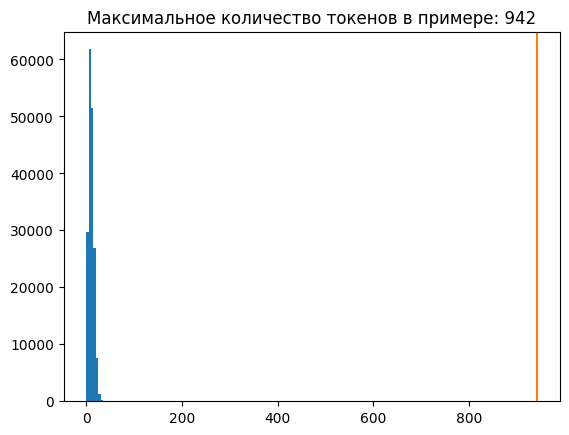

In [ ]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum number of tokens in an example: {max_length}');

Based on the graph, we choose the maximum length of phrases:

In [ ]:
MAX_TOKENS=32

#### Adding [START] and [END] tokens

With `reserved_tokens` we have already included the `[START]` and `[END]` tokens in the dictionary. Now we need to add tokens to all phrases, they have the same indexes for both languages:

In [ ]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

Let's look at an example with added tokens:

In [ ]:
words = tokenizer.detokenize(add_start_end(token_batch))
tf.strings.reduce_join(words, separator=' ', axis=-1)

# Joining and decoding
joined_text = tf.strings.reduce_join(words, separator=' ', axis=-1)
decoded_texts = [text.numpy().decode('utf-8') for text in joined_text]

# Output results
for text in decoded_texts:
    print(text)

[START] от подарка любимого человека . каким бы подарок ни был . [END]
[START] лучшая машина новая [END]
[START] роюсь в карманах спящего мужа . [END]


### Clearing text during detokenization

We want to make sure that when we detokenize, we immediately get a string instead of tensors, and that the output strings do not contain reserved tokens. For this purpose we will write an auxiliary function:

In [ ]:
def cleanup_text(reserved_tokens, token_txt):
    # Deleting tokens other than "[UNK]".
    # Search for reserved tokens except [UNK]
    bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]]
    # Join "bad" tokens for regularization with OR (|)
    bad_token_re = "|".join(bad_tokens)

    # Search the string for regular
    bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
    # Sift all found inclusions of "bad" tokens from the source string
    result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

    # String chaining.
    result = tf.strings.reduce_join(result, separator=' ', axis=-1)

    return result

Re-sample the strings since en_examples has been overridden:

In [ ]:
print('Let's select the lines for the example:')
for q_examples, a_examples in train_dataset.batch(3).take(1):
    for ex in a_examples:
        # Decode each example
        decoded_ex = ex.numpy().decode('utf-8')
        print(decoded_ex)

Отберем строки для примера:
от подарка любимого человека. каким бы подарок ни был.
лучшая машина новая
роюсь в карманах спящего мужа.


In [ ]:
# Decode the whole batch
decoded_a_examples = [ex.numpy().decode('utf-8') for ex in a_examples]
print(decoded_a_examples)

['от подарка любимого человека. каким бы подарок ни был.', 'лучшая машина новая', 'роюсь в карманах спящего мужа.']


And this is the view after cleaning:

In [ ]:
result = cleanup_text(reserved_tokens, words)
# Converting a byte array to readable strings
decoded_result = [item.decode('utf-8') for item in result.numpy()]
print("Decoded result:", decoded_result)

Декодированный результат: ['от подарка любимого человека . каким бы подарок ни был .', 'лучшая машина новая', 'роюсь в карманах спящего мужа .']


#### Creating a custom tokenizer

Let's create our own custom `CustomTokenizer` class based on `text.BertTokenizer`, with additional custom logic, and `@tf.function` wrappers needed for exporting.

In [ ]:
import tensorflow as tf
import tensorflow_text as text
import pathlib

# Tokenizer class
class CustomTokenizer(tf.Module):
    def __init__(self, reserved_tokens, vocab_path):
        # Reserved tokens
        self._reserved_tokens = reserved_tokens
        # Dictionary file path
        self._vocab_path = tf.saved_model.Asset(vocab_path)

        # Read dictionary from file
        vocab = pathlib.Path(vocab_path).read_text().splitlines()
        self.vocab = tf.constant(vocab) # Use tf.constant instead of tf.Variable

        # Initialize the BERT tokenizer
        self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)

        # Create signatures for methods
        self.tokenize.get_concrete_function(
            tf.TensorSpec(shape=[None], dtype=tf.string))

        self.detokenize.get_concrete_function(
            tf.TensorSpec(shape=[None, None], dtype=tf.int64))

        self.lookup.get_concrete_function(
            tf.TensorSpec(shape=[None, None], dtype=tf.int64))

        self.get_vocab_size.get_concrete_function()
        self.get_vocab_path.get_concrete_function()
        self.get_reserved_tokens.get_concrete_function()

    @tf.function
    def tokenize(self, strings):
        enc = self.tokenizer.tokenize(strings)
        enc = enc.merge_dims(-2, -1)
        enc = add_start_end(enc)
        return enc

    @tf.function
    def detokenize(self, tokenized):
        words = self.tokenizer.detokenize(tokenized)
        return cleanup_text(self._reserved_tokens, words)

    @tf.function
    def lookup(self, token_ids):
        return tf.gather(self.vocab, token_ids)

    @tf.function
    def get_vocab_size(self):
        return tf.shape(self.vocab)[0]

    @tf.function
    def get_vocab_path(self):
        return self._vocab_path

    @tf.function
    def get_reserved_tokens(self):
        return tf.constant(self._reserved_tokens)

In [ ]:
tokenizers = tf.Module()
tokenizers = CustomTokenizer(reserved_tokens, 'vocab.txt')

And save the module and refer to it when we need it.

In [ ]:
model_name = 'converter'
tf.saved_model.save(tokenizers, model_name)

Working with tokenization is now much more convenient.

Example of tokenization:

In [ ]:
encoded = tokenizers.tokenize(a_examples)

for row in encoded.to_list():
  print(row)

[2, 84, 232, 3164, 1174, 196, 7, 421, 99, 904, 182, 255, 7, 3]
[2, 2154, 1197, 2432, 3]
[2, 52, 3752, 144, 39, 4508, 4692, 2548, 53, 389, 108, 1229, 669, 7, 3]


Note the token 2 at the beginning of the string and 3 at the end. The `[START]` and `[END]` tokens are already added to our strings.

Let's perform reverse detokenization:

In [ ]:
round_trip = tokenizers.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

от подарка любимого человека . каким бы подарок ни был .
лучшая машина новая
роюсь в карманах спящего мужа .


The `lookup` method converts token identifiers into a textual representation of tokens:

In [ ]:
tokens = tokenizers.lookup(encoded)
# Decoding byte strings inside tf.RaggedTensor
decoded_tokens = [[token.decode('utf-8') for token in row.numpy()] for row in tokens]
print(decoded_tokens)

[['[START]', 'от', 'под', '##арка', 'любимого', 'человека', '.', 'каким', 'бы', 'подарок', 'ни', 'был', '.', '[END]'], ['[START]', 'лучшая', 'машина', 'новая', '[END]'], ['[START]', 'р', '##ою', '##сь', 'в', 'ка', '##рма', '##нах', 'с', '##п', '##я', '##щего', 'мужа', '.', '[END]']]


## Dataset preparation, data preprocessing

Let us define a helper function `prepare_batch` to prepare the dataset to a view suitable for use in the `fit` training method:

In [ ]:
def prepare_batch(questions, answers):
    questions = tokenizers.tokenize(questions) # Tokenize data
    questions = questions[:, :MAX_TOKENS] # Align data to MAX_TOKENS.
    questions = questions.to_tensor() # Convert to a tensor with uniform dimensions

    answers = tokenizers.tokenize(answers)
    answers = answers[:, :(MAX_TOKENS+1)]
    answers_inputs = answers[:, :-1].to_tensor() # Remove [END] tokens (decoder input)
    answers_labels = answers[:, 1:].to_tensor() # Remove [START] tokens (decoder output)

    return (questions, answers_inputs), answers_labels

This function takes packets of text as input and converts them into a format suitable for training, viz:
* splits the data into individual packets.
* truncates each one so that it is no longer than MAX_TOKENS.
* splits the target (English) tokens into input data and labels, and shifts them by one step, so that the target tokens are offset one token from the input tokens.
* converts RaggedTensors (measurement slices can have different lengths) into tensors with uniform measurements.
* returns a pair (input data, tokens).

Let's define the constants for packet formation:

In [ ]:
# Buffer size in memory when preparing a dataset
BUFFER_SIZE = 20000

# Packet size
BATCH_SIZE = 128

Let's run the phrases through the prepared function and form packets:

In [ ]:
def make_batches(ds):
  return (
            ds
            .shuffle(BUFFER_SIZE) # shuffle the data
            .batch(BATCH_SIZE) # divide the dataset into batches
            .map(prepare_batch, tf.data.AUTOTUNE) # apply prepare_batch
            .prefetch(buffer_size=tf.data.AUTOTUNE))  # prefetch is used to separate the time when data is prepared and consumed, which speeds up network training

 </section>

Create training and validation sampling packages:

In [ ]:
train_batches = make_batches(train_dataset)
val_batches = make_batches(val_dataset)

Let's display the shape of a single package:

In [ ]:
for (q, a), a_labels in train_batches.take(1):
  break

print(q.shape)
print(a.shape)
print(a_labels.shape)

(128, 32)
(128, 32)
(128, 32)


## Model Architecture

Let's assemble the model piece by piece. Let's start with embeddings and position coding.

### Position coding and embeddings

In [ ]:
# length - word number in the phrase
# depth - size of embedding space
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[::, np.newaxis] # shape (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth # shape (1, depth)


    angle_rates = 1 / (10000**depths) # shape (1, depth)
    angle_rads = positions * angle_rates # shape (pos, depth)

    pos_encoding = np.concatenate(
    [np.sin(angle_rads), np.cos(angle_rads)],
    axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32) # specify type of returned data

Let's test the operation of the function:

In [ ]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Let's check the mold
print(pos_encoding.shape)

(2048, 512)


Create a `Position Embedding` layer

In [ ]:
# Inherit the class from tf.keras.layers.Layer
# Now our layer is also a Keras class
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) # embedding
        self.pos_encoding = positional_encoding(length=2048, depth=d_model) # positional encoding

  # This method returns the embedding mask.
  # Since the vectors are aligned to the same length using pad_sequences,
  # the method will return True for non-zero tokens, and False for zero tokens.

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)

        # This factor specifies the relative scale of embedding and position coding
        # You can and should play with this parameter!
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

Let's see how the layer works:

In [ ]:
embed_q = PositionalEmbedding(vocab_size=tokenizers.get_vocab_size().numpy(), d_model=512)
embed_a = PositionalEmbedding(vocab_size=tokenizers.get_vocab_size().numpy(), d_model=512)

q_emb = embed_q(q)
a_emb = embed_a(a)

Let's bring out the mask:

In [ ]:
a_emb._keras_mask

<tf.Tensor: shape=(128, 32), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Normalization and residual coupling (pooling)

### Basic Attention Class

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

### Encoder-Decoder Attention

In [ ]:
class CrossAttention(BaseAttention):
 def call(self, x, context):
    # Pass signal through multi-headed attention
    attn_output, attn_scores = self.mha(
        query=x, # query
        key=context, # key
        value=context, # value
        return_attention_scores=True) # return attention scores

    # Save the scores for the future
    self.last_attn_scores = attn_scores

    # Add residual linkage and normalization
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

Let's look at an example of a signal traveling through a layer:

In [ ]:
# When initializing through the base class we pass to the layer tf.keras.layers.MultiHeadAttention
# parameters num_heads - number of heads, key_dim - key dimensionality
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(q_emb.shape)
print(a_emb.shape)
print(sample_ca(a_emb, q_emb).shape)

(128, 32, 512)
(128, 32, 512)
(128, 32, 512)


### Layer GlobalSelfAttention

In [ ]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
    # Pass the signal through multi-headed attention
    attn_output = self.mha(
        query=x, # query
        value=x, # key
        key=x) # value

    # Add residual communication and normalization
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

Let's pass the signal through the `GlobalSelfAttention` layer with two heads and look at the dimensions, once again making sure that the output sequence matches the `query`. Such checks at the design stage help to avoid errors during the whole model assembly.

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(q_emb.shape)
print(sample_gsa(q_emb).shape)

(128, 32, 512)
(128, 32, 512)


### CausalSelfAttention layer.

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)  # differs from GlobalSelfAttention by one argument
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

Let's test that the layer is working properly:

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(a_emb.shape)
print(sample_csa(a_emb).shape)

(128, 32, 512)
(128, 32, 512)


The output for early elements in the sequence is independent of later elements, so it shouldn't matter whether you crop elements before or after applying the layer (you should get a very small number):

In [ ]:
out1 = sample_csa(embed_a(a[:, :3]))
out2 = sample_csa(embed_a(a))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

np.float32(0.14335728)

### Feed forward network

The network consists of two `Dense' layers (Relu and linear activation), and a `Dropout' regularization layer. As with the attention layers, we also add residual coupling and normalization:

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

Here `dff` is the dimensionality of the first `Dense` layer, `d_model` is the dimensionality of the embeddings and our second `Dense` layer (we try to match the original paper as closely as possible), `dropout_rate` is the regularization parameter.

Let's test the layer and make sure that the output will have the same shape as the input:

In [ ]:
sample_ffn = FeedForward(512, 2048)

print(a_emb.shape)
print(sample_ffn(a_emb).shape)

(128, 32, 512)
(128, 32, 512)


## Assemble the entire network

### Encoder Layer

Let's define one encoder layer `EncoderLayer`:

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,  # number of heads
        key_dim=d_model, # key dimension
        dropout=dropout_rate) # regularization level

    self.ffn = FeedForward(d_model, dff) # number of neurons in the second and first Dense layer, respectively

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

And we'll do the test right away:

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(q_emb.shape)
print(sample_encoder_layer(q_emb).shape)

(128, 32, 512)
(128, 32, 512)


### Encoder Unit

The encoder block consists of an input `PositionalEmbedding` layer at the input and a stack of `EncoderLayer` layers:

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    # Initiate variables inside the class
    self.d_model = d_model
    self.num_layers = num_layers

    # Create a class object for the positional encoding class
    self.pos_embedding = PositionalEmbedding(
    vocab_size=vocab_size, d_model=d_model)

    # Create a class object for the encoder layer
    self.enc_layers = [
    EncoderLayer(d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    dropout_rate=dropout_rate)
    for _ in range(num_layers)]

    # Create a class object for the regularization layer
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # Shape x token: (batch, seq_len)
    # Run the token sequence through the positional encoding layer
    x = self.pos_embedding(x) # output shape (batch_size, seq_len, d_model)

    # Run the token sequence through the regularization layer
    x = self.dropout(x)

    # Run the token sequence through the num_layers of the encoder layers
    for i in range(self.num_layers):
        x = self.enc_layers[i](x)

    return x # output form (batch_size, seq_len, d_model)

Let's test the encoder:

In [ ]:
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=VOCAB_SIZE)

sample_encoder_output = sample_encoder(q, training=False)

print(q.shape)
print(sample_encoder_output.shape)  # output form (batch_size, input_seq_len, d_model)

(128, 32)
(128, 32, 512)


### Decoder Layer

The decoder stack is a bit more complex, as each decoder layer contains a `CausalSelfAttention` layer, a `CrossAttention` layer, and a `FeedForward` layer:

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    # Causal Attention Layer
    self.causal_self_attention = CausalSelfAttention(
    num_heads=num_heads,
    key_dim=d_model,
    dropout=dropout_rate)

    # Layer with cross-attention
    self.cross_attention = CrossAttention(
    num_heads=num_heads,
    key_dim=d_model,
    dropout=dropout_rate)

    # FeedForward Layer
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    # Pass a sequence of tokens through:
    # Causal attention layer
    x = self.causal_self_attention(x=x)
    # Cross attention layer and context vector from the encoder
    x = self.cross_attention(x=x, context=context)

    # Memorize attention estimates for the future
    self.last_attn_scores = self.cross_attention.last_attn_scores
    # Through the forward propagation layer
    x = self.ffn(x) # Form `(batch_size, seq_len, d_model)`.
    return x

Let's test our decoder layer:

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=a_emb, context=q_emb)

print(a_emb.shape)
print(q_emb.shape)
print(sample_decoder_layer_output.shape)  # Output form `(batch_size, seq_len, d_model)`

(128, 32, 512)
(128, 32, 512)
(128, 32, 512)


### Decoder Unit

Let's define the decoder entirely as an inheritor of the keras layer class `tf.keras.layers.Layer`:

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    # Initiate variables inside the class
    self.d_model = d_model
    self.num_layers = num_layers

    # Create class object for positional encoding
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
    d_model=d_model)
    # Create a class object for the regularization layer
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    # Create a stack of decoder layers at once using a list generator based on the number of layers
    self.dec_layers = [
    DecoderLayer(d_model=d_model, num_heads=num_heads,
    dff=dff, dropout_rate=dropout_rate)
    for _ in range(num_layers)]

    # Reset attention scores
    self.last_attn_scores = None

  def call(self, x, context):
    # Feed a sequence of tokens x to the input form (batch, target_seq_len)

    # Pass through a layer of positional encoding (and of course embedding)
    x = self.pos_embedding(x) # output form (batch_size, target_seq_len, d_model)

    # Regularize
    x = self.dropout(x)

    # Run through num_layers of decoder layers
    for i in range(self.num_layers):
      x = self.dec_layers[i](x, context)

    # Save the attention estimates from the last layer
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # Shape x to output (batch_size, target_seq_len, d_model)
    return x

Let's test the whole decoder:

In [ ]:
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=a,
    context=q_emb)

print(a.shape)
print(q_emb.shape)
print(output.shape)

(128, 32)
(128, 32, 512)
(128, 32, 512)


In [ ]:
sample_decoder.last_attn_scores.shape # form of attention estimates at the decoder output (batch, heads, target_seq, input_seq)

TensorShape([128, 8, 32, 32])

## Transformer ##

Thus, we have written the `Encoder` and `Decoder` classes. To get the `Transformer` model in its entirety, we need to combine them and add a final `Dense` layer that converts the resultant vector at each position into probabilities of output tokens.

The output of the decoder is the input to this final layer.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    # Encoder
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)
    # Decoder
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)
    # Final layer
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use the `.fit' method to train the model, you need to pass
    # all input data in the first argument
    context, x = inputs

    # Pass context to encoder
    context = self.encoder(context) # output data form (batch_size, context_len, d_model)

    # Pass context and target vector to decoder
    x = self.decoder(x, context) # output form (batch_size, target_len, d_model)

    # Run the output through the final layer
    logits = self.final_layer(x) # output data form (batch_size, target_len, target_vocab_size)

    try:
      # After the data has passed through all the layers, the
      # the mask so that it does not scale, loss and metrics
      # The error handler avoids exceptions when we try to delete
        del logits._keras_mask
    except AttributeError: # catch the error of no attribute
        pass

    # Return our logits
    return logits

## Model training

Let's start by defining the parameters for our transformer. To keep this example small and relatively fast, we will reduce the number of layers (`num_layers`), the embedding dimension (`d_model`), the number of heads (`num_heads`), and the direct link layer dimension (`dff`).

The base model (original paper) used `num_layers=6`, `d_model=512`, `dff=2048`, `num_heads=8`.

In [ ]:
num_layers = 2
d_model = 128
dff = 256
num_heads = 4
dropout_rate = 0.1

EPOCHS = 3

Assemble the transformer with the given parameters:

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Let's test the Transformer:

In [ ]:
output = transformer((q, a))

print(a.shape)
print(q.shape)
print(output.shape)

(128, 32)
(128, 32)
(128, 32, 7730)


Let's test the attention estimates in the output, we are interested in their shape:

In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # Form of attention assessments: (batch, heads, target_seq, input_seq)

(128, 4, 32, 32)


### Optimizer

Use the `Adam` optimizer with a customizable learning rate scheduler according to the formula given in the original article [Attention Is All You Need](https://arxiv.org/pdf/1706.03762):

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

Let's create a CustomSchedule class to create custom optimizer settings:

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

The formula corresponds to a linear increase in learning rate during the first stages of training `warmup_steps` and its subsequent decrease in proportion to the root inverse of the square root of the step number. The article used a value of `warmup_steps` = 4000. We will take it as in the article.

Then the learning rate for the optimizer is set as an instance of the class:

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Let's determine the number of training steps per epoch:

In [ ]:
# Number of batches for training
num_batches = 0
for (batch, (_,_)) in enumerate(train_batches):
  num_batches = batch
print(num_batches)

703


Learning speed at every step when considering that we plan to teach at 10 epochs:

Text(0.5, 0, 'Шаг обучения')

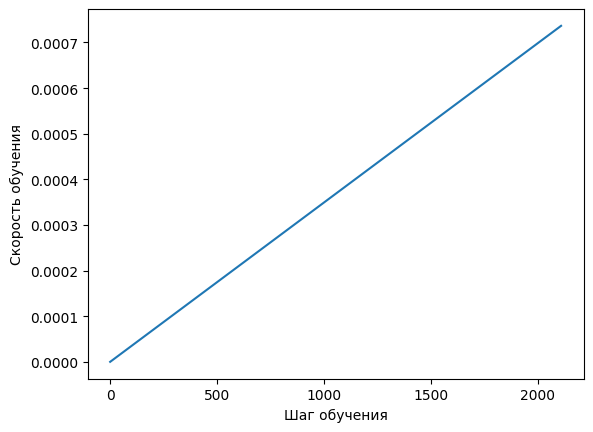

In [ ]:
plt.plot(learning_rate(tf.range(num_batches*EPOCHS, dtype=tf.float32)))
plt.ylabel('Speed of learning')
plt.xlabel('Learning Step')

The best results of this model were shown at 50 epochs of training, and it is understandable, for this experiment the graph of training speed includes not only the area of “warm-up” and training with a constant decrease in speed, which is more logical.

Text(0.5, 0, 'Шаг обучения')

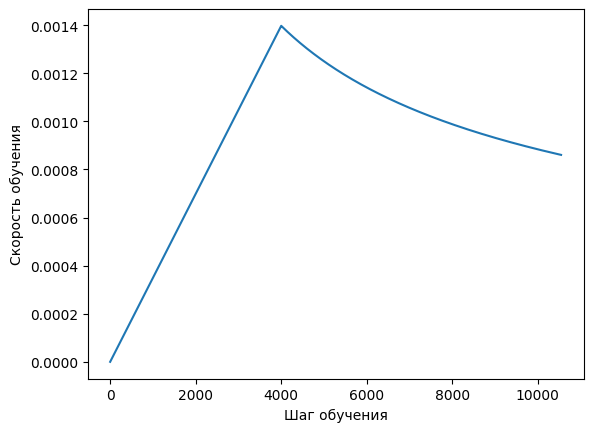

In [ ]:
plt.plot(learning_rate(tf.range(num_batches*EPOCHS*5, dtype=tf.float32)))
plt.ylabel('Speed of learning')
plt.xlabel('Learning Step')

### Loss function and metrics

Since the target sequences are aligned and filled with zeros until the end of the sequence, it is important to apply a fill mask when calculating losses.

We will apply the discharged categorical cross entropy `tf.keras.losses.SparseCategoricalCrossentropy` as the loss function:

In [ ]:
# Masked loss function
def masked_loss(label, pred):
  # Define a mask where labels are not equal to 0
 mask = label != 0
  # Define loss function
 loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
 from_logits=True, reduction='none')
 loss = loss_object(label, pred)

  # It is important that mask and loss have the same data type
 mask = tf.cast(mask, dtype=loss.dtype)
  # Overlay mask on loss
 loss *= mask

  # Scaling loss to mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

# Masked accuracy function
def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    # Evaluate whether the label and prediction match
    match = label == pred
    # Set mask where labels are not equal to 0
    mask = label != 0

    # Logical AND
    match = match & mask

    # Convert to the same type and scale matches to the mask
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Compile and train the model

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_batches,
                epochs=EPOCHS,
                validation_data=val_batches)

Epoch 1/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 3605s 5s/step - loss: 8.1502 - masked_accuracy: 0.0481 - val_loss: 6.1960 - val_masked_accuracy: 0.1044
Epoch 2/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 3585s 5s/step - loss: 5.9925 - masked_accuracy: 0.1150 - val_loss: 5.5268 - val_masked_accuracy: 0.1325
Epoch 3/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 3588s 5s/step - loss: 5.3856 - masked_accuracy: 0.1417 - val_loss: 5.1883 - val_masked_accuracy: 0.1470


## Model Execution (Inference)

Now we can test the model, for this we will formalize the QA class as a tensorflow module:

In [ ]:
class QA(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):

    assert isinstance(sentence, tf.Tensor) # Check that the sequence is a tensor
    if len(sentence.shape) == 0:
        sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.tokenize(sentence).to_tensor()
    # The input sentence is written in Portuguese
    encoder_input = sentence

    # Since the output language is English, initialize the output with the token [START]
    start_end = self.tokenizers.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # A tf.TensorArray` (instead of a Python list) is required here so that the dynamic loop
    # can be tracked with `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      # at each step put the output tokens into an array for
      # transfer to the input at the next step
        output = tf.transpose(output_array.stack())
      # pass to transformer for prediction tokens
        predictions = self.transformer([encoder_input, output], training=False)

      # select the last token from the `seq_len` dimension
      predictions = predictions[:, -1:, :] # form `(batch_size, 1, vocab_size)`.

      # Predicted token
        predicted_id = tf.argmax(predictions, axis=-1)

      # Combine `predicted_id` with the output data, which is passed to the
      # to the decoder as input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # Tokens to text
    text = tokenizers.detokenize(output)[0] # Shape: `()`.

    tokens = tokenizers.lookup(output)[0]

    # `tf.function` prevents us from using attention_weight values that were
    # calculated at the last iteration of the loop.
    # So let's recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Let's create an instance of the Translator class and test it on a few phrases:

In [ ]:
qa_model = QA(tokenizers, transformer)

In [ ]:
def print_answer(sentence, tokens, ground_truth):
  print(f'{"Question:":25s}: {sentence}')
  print(f'{"Predicted answer:":25s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Original answer":25s}: {ground_truth}')

In [ ]:
counter = 0
random_rows = val_df.sample(n=5)
for _, row in random_rows.iterrows():
    question_text = row['question']
    ground_truth = row['answer']
    answer_text, answer_tokens, attention_weights = qa_model(tf.constant(question_text))
    counter += 1
    print(f"Example {counter}")
    print_answer(question_text, answer_text, ground_truth)
    print()

Пример 1
Вопрос:                  : вы в свой выходной куда выходите?
Предсказанный ответ:     : в стекром и верх . верх .
Оригинальный перевод     : в выходной спокойно выхожу. на кухню. а так обычно бегом.

Пример 2
Вопрос:                  : вы многое поняли? все во время или с опозданием?
Предсказанный ответ:     : я не люблю . но не люблю .
Оригинальный перевод     : я верю в судьбу, значит все вовремя, хотя вот лично я иногда думаю где глаза были и мозги

Пример 3
Вопрос:                  : мужчины, что вы делаете когда вам нравится девушка, но у нее слишком много тараканов в голове?
Предсказанный ответ:     : я не люблю . но не люблю .
Оригинальный перевод     : покупаю клетку. для этих тараканов.

Пример 4
Вопрос:                  : можно просто так посидеть в кафе?
Предсказанный ответ:     : да , я не люблю . но не верватив .
Оригинальный перевод     : можно, но заказать хоть корочку хлеба нужно обязательно

Пример 5
Вопрос:                  : малфой
Предсказанный ответ:     :

The answers are so-so, but the number of eras when learning is only 3!

## Attention Schedule

Let's create an attention function:

In [ ]:
def plot_attention_head(in_tokens, answer_tokens, attention):
  # Passing the token `[START]`
  answer_tokens = answer_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(answer_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in answer_tokens.numpy()]
  ax.set_yticklabels(labels)

We are interested, for example, in the attention of a head with index 0. As input, we have attention scores `attention_weights`: with the form `(batch=1, num_heads, seq_len_q, seq_len_k)`.

In [ ]:
head = 0 # head number
# form attention_weights: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0) # remove the zero dimension of the tensor
attention = attention_heads[head] # select the desired head
attention.shape

TensorShape([18, 6])

Input Question Sequence:

In [ ]:
in_tokens = tf.convert_to_tensor([question_text])
in_tokens = tokenizers.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.lookup(in_tokens)[0]

in_tokens_decoded = [token.decode('utf-8') for token in in_tokens.numpy()]
in_tokens_decoded

['[START]', 'м', '##ал', '##ф', '##ои', '[END]']

Exit Response:

In [ ]:
answer_tokens_decoded = [token.decode('utf-8') for token in answer_tokens.numpy()]
answer_tokens_decoded

['[START]',
 'а',
 'я',
 'не',
 'с',
 '##та',
 '##р',
 '##ба',
 ',',
 'а',
 'там',
 'и',
 'не',
 'с',
 '##та',
 '##р',
 '##ба',
 '##и',
 '[END]']

Attention graph for 0 head:

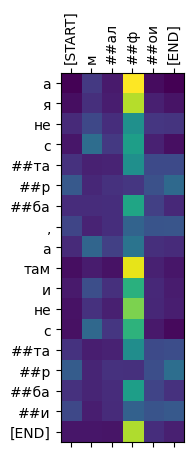

In [ ]:
plot_attention_head(in_tokens, answer_tokens, attention)

It is possible to output at once in a loop for all goals:

In [ ]:
def plot_attention_weights(sentence, answer_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, answer_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

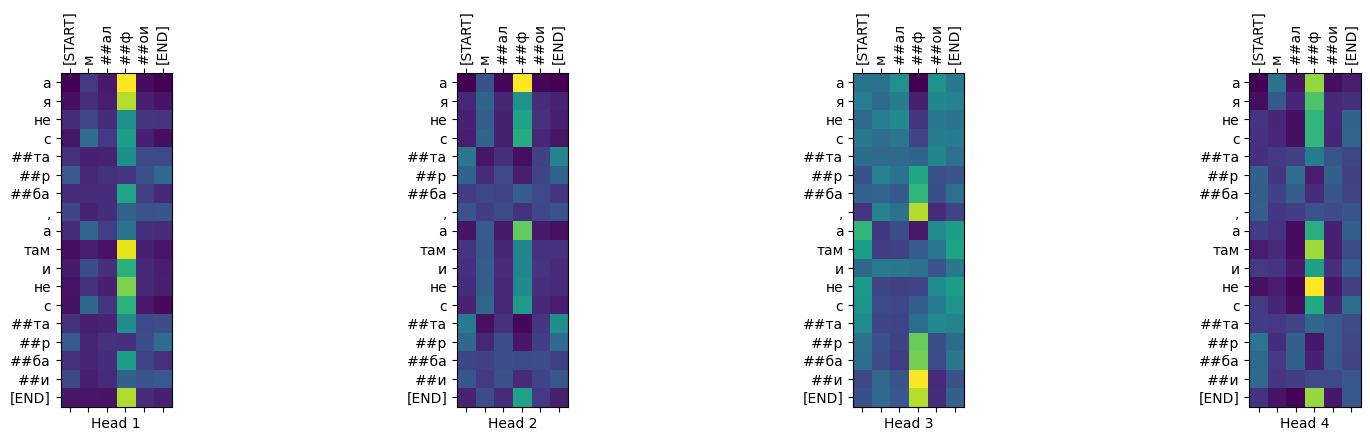

In [ ]:
plot_attention_weights(question_text,
                       answer_tokens,
                       attention_weights[0])

As you can see from the heat maps: each head works differently, all heat maps are different.

## Exporting a model

We have tested the model, it works, it produces good results, so we should save it and use it in our projects.

The model can be exported as `tf.saved_model`. To learn about saving and loading a model in `SavedModel` format, use [this](https://www.tensorflow.org/guide/saved_model) guide.

Let's start creating the module. To do this, create a class named `ExportTranslator` and inherit it from `tf.Module`:

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In fact, our new module simply calls the previously created `Translator` class in the `__call__` method wrapped in `@tf.function`.

Transfer the translator to the newly created ExportTranslator:

In [ ]:
qa_model = ExportTranslator(qa_model)

Since the model decodes the predictions using `tf.argmax`, the predictions are deterministic. The original model and the model re-loaded from the stored model should produce identical predictions, let's check this assumption:

In [ ]:
qa_model('как у тебя дела?').numpy().decode('utf-8')

'я не люблю , но я не люблю .'

Save the model to a folder:

In [ ]:
tf.saved_model.save(qa_model, export_dir='qa_model')

Save the model from the folder:

In [ ]:
reloaded = tf.saved_model.load('qa_model')

# Generate a prediction

In [ ]:
reloaded('как у тебя дела?').numpy().decode('utf-8')

'я не люблю , но я не люблю .'